<a href="https://colab.research.google.com/github/pszemraj/vid2cleantxt/blob/master/Topic_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Models - Optimize and Plot

Now evaluate the best topic model. Source code (that I edited) also taken from [medium](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0). 



#### What is topic coherence?
Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.


**Coherence:**
A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is "the game is a team sport", "the game is played with a ball", "the game demands great physical efforts"




** **
# Loading Data
** **

### Setup display

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

### mount google drive

In [ ]:
# create interface to upload / interact with google drive and video files
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

### Add monitoring 
from [hyperdash](https://github.com/hyperdashio/hyperdash-sdk-py) can be removed

In [ ]:
%%capture
!pip install -U hyperdash

In [ ]:
!hd login --github
from hyperdash import monitor_cell

Opening browser, please wait. If something goes wrong, press CTRL+C to cancel.
 SSH'd into a remote machine, or just don't have access to a browser? Open this link in any browser and then copy/paste the provided access token: https://hyperdash.io/oauth/github/start?state=client_cli_manual 
Waiting for Github OAuth to complete.
If something goes wrong, press CTRL+C to cancel.
Access token: 5nbG5YLAj2rvlngyZzFlPdUjrN+huxyLtgbyTddhl7c=
Successfully logged in! We also installed: gVD9HxGR3kC4pFLZRoTH13CMuF59K3mHn/0Z4dPnxF4= as your default API key


### install packages


In [ ]:
%%capture
# Importing base modules
!pip install -U spacy
!pip install -U natsort
!pip install -U texthero
!pip install -U wordninja

import os
import pprint as pp
from datetime import datetime
from os import listdir
from os.path import isfile, join
import time
from datetime import datetime
import pandas as pd
import spacy
import re
import texthero as hero
from texthero import preprocessing
import wordninja

from natsort import natsorted
from natsort import *
from google.colab import data_table


run_date = datetime.now()
day_suffix = run_date.strftime("_%d%m%Y_")


### define filename + other key params

read in data as well

In [ ]:
# KEY USER ENTERED PARAMETERS
dataset_name = "StatsLab - UW SISCER Topics" + day_suffix
desired_trials = 200 # th
file_directory = "/content/drive/My Drive/Programming/topic_models"
subfolder = "UW_siscer"
filename = 'UWSISCER_SpellCorrected.ftr'
# filename = 'heather_msg_df_postKmeans.ftr'
# Read data into papers (need to rename later)
out_directory = join(file_directory, subfolder)
papers = pd.read_feather(os.path.join(file_directory, subfolder, filename))
# papers_sorted = papers.sort_values(key=natsort_keygen(), by="doc name")

** **
## Data Cleaning
** **

drop unneeded columns, get rid of punctuation, etc

In [ ]:
%load_ext google.colab.data_table

# get basic description of dataset
papers = papers.convert_dtypes() # convert data types after loading
pp.pprint(papers.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_in_doc    30 non-null     string
 1   doc name       30 non-null     string
 2   pca            30 non-null     object
 3   cleaner        30 non-null     string
 4   cleanest       30 non-null     string
 5   tfidf          30 non-null     object
 6   kmeans_labels  30 non-null     string
 7   TSNE_points    30 non-null     object
dtypes: object(3), string(5)
memory usage: 2.0+ KB
None


In [ ]:
# Remove the columns

papers.drop(columns=['pca', 'cleaner', 'tfidf', 'TSNE_points'], 
            axis=1, inplace=True)
# papers.drop(columns='Attachment', inplace=True)
# papers['cleanest'] = papers['clean_text'].copy()
# papers['doc name'] = papers['Sender Name'].copy()
# papers['text_in_doc'] = papers['Text'].copy()
# Print out the first rows of papers after making changes
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_in_doc    30 non-null     string
 1   doc name       30 non-null     string
 2   cleanest       30 non-null     string
 3   kmeans_labels  30 non-null     string
dtypes: string(4)
memory usage: 1.1 KB


### Remove punctuation/lower casing

Next, let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [ ]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = papers['text_in_doc'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['text_in_doc'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head(10)

0    1 module 17 joint modeling of longitudinal and...
1    1 modern statistical learning methods for obse...
2    1 module 2 introduction to longitudinal data a...
3    1 modern statistical learning methods for obse...
4    1 bayesian adaptive clinical trial design jaso...
5    1 modern statistical learning methods for obse...
6    1 bayesian adaptive designs for clinical trial...
7    1 modern statistical learning methods for obse...
8    1 bayesian adaptive designs for clinical trial...
9    1 modern statistical learning methods for obse...
Name: paper_text_processed, dtype: object

# Prepare and Optimize Model

##### Tokenize words and further clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

In [ ]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

unused_data = papers.paper_text_processed.tolist()
unused_data_words = list(sent_to_words(unused_data))
data = papers.cleanest.tolist() # use cleanest instead
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['module', 'joint', 'modeling', 'longitudinal', 'survival', 'benjamin', 'french', 'phd', 'radiation', 'effects', 'research', 'foundation', 'siscer', 'july', 'learning', 'objectives', 'focus', 'combining', 'repeated', 'measures', 'survival', 'times', 'joint', 'regression', 'chapters', 'rizopoulous', 'asar', 'studies', 'analysis', 'strategies']


In [ ]:
# create dataframe for word counting

DW_df = pd.Series(data_words, name="data_words_in_doc")

def join_df_items(textlist):
    big_string = " ".join(textlist)

    return big_string

papers['data_words'] = DW_df.apply(join_df_items)

papers = papers.convert_dtypes()
print("\n papers dataframe as follows: \n")
pp.pprint(papers.info())
pp.pprint(papers["data_words"].head())


 papers dataframe as follows: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   text_in_doc           30 non-null     string
 1   doc name              30 non-null     string
 2   cleanest              30 non-null     string
 3   kmeans_labels         30 non-null     string
 4   paper_text_processed  30 non-null     string
 5   data_words            30 non-null     string
dtypes: string(6)
memory usage: 1.5 KB
None
0    module joint modeling longitudinal survival be...
1    modern statistical learning methods observatio...
2    module longitudinal analysis colleen sitlani p...
3    modern statistical learning methods observatio...
4    bayesian adaptive clinical trial design jason ...
Name: data_words, dtype: string


** **
#### Step 3: Phrase Modeling: Bigram and Trigram Models
** **

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Some examples in our example are: 'back_bumper', 'oil_leakage', 'maryland_college_park' etc.

Gensim's Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold.

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Viz Most Frequent Words

how to make bar chart:
* guide [here](https://plotly.com/python/bar-charts/)
* documentation [here](https://plotly.com/python-api-reference/generated/plotly.express.bar)

In [ ]:
# -------------------------------------------------------------------------------------------------------
# User enters
desired_top_words = 25


# -------------------------------------------------------------------------------------------------------
# admin stuff 
print("\n top {0:3d} words (after generic stopword removal) are as follows \n".format(desired_top_words))
np_top_words = hero.top_words(hero.remove_stopwords(papers["data_words"]))
the_top_words = pd.DataFrame(np_top_words)
# pp.pprint(the_top_words.iloc[0:desired_top_words])
the_top_words["Word"] = the_top_words.index
total_word_count = the_top_words["data_words"].sum()
total_unique_words = len(the_top_words["Word"])
exp_freq = 100 / total_unique_words # if evenly dist

print("baseline percentage for {0:5d} unique words is: ".format(total_unique_words),
      "{0:6.4f} Percent of corpus\n\n".format(exp_freq))

def compute_perc_rep(w_count):
    return (w_count / total_word_count) * 100
the_top_words["perc_corpus"] = the_top_words["data_words"].apply(compute_perc_rep)
the_top_words["rep_vs_baseline_ABS"] = the_top_words["perc_corpus"] - exp_freq # absolute percentage
the_top_words["rep_vs_baseline"] = the_top_words["rep_vs_baseline_ABS"] / exp_freq # shown as multiple of what the baseline is

# round
the_top_words["perc_corpus"] = the_top_words["perc_corpus"].apply(round, ndigits=4)
the_top_words["rep_vs_baseline_ABS"] = the_top_words["rep_vs_baseline_ABS"].apply(round, ndigits=3)
the_top_words["rep_vs_baseline"] = the_top_words["rep_vs_baseline"].apply(round, ndigits=0)
import plotly.express as px

labels_for_chart = {
    "rep_vs_baseline": "Comparison vs. Avg. Word Freq (Multiplier)",
    "perc_corpus": "Percentage of Total Corpus",
    "rep_vs_baseline_ABS": "Diff vs. Avg. Word Freq %",
    "data_words": "Count of Word",
} # usage - labels=
fig_wc = None
fig_wc = px.bar(the_top_words.iloc[0:desired_top_words,], x="Word", color="rep_vs_baseline",
                y='data_words', title="top {0:3d} words in ".format(desired_top_words) + dataset_name,
                hover_data = ["Word", "data_words", "perc_corpus", "rep_vs_baseline_ABS"],
                text="rep_vs_baseline", labels=labels_for_chart, template="seaborn")
fig_wc.show()


 top  25 words (after generic stopword removal) are as follows 

baseline percentage for  6999 unique words is:  0.0143 Percent of corpus




/usr/local/lib/python3.7/dist-packages/texthero/visualization.py:182: FutureWarning: The default value of regex will change from True to False in a future version.
  pattern, r"\2 \3"


### Remove Stopwords, Make Bigrams and Lemmatize

The phrase models are ready. Let’s define the functions to remove the stopwords, make trigrams and lemmatization and call them sequentially.

In [ ]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
IML_stop_words = ['one', 'actually', 'want', 'see', 'right', 'like', 'spring', 'example', 'really', 'going',
                   'yes', 'look', 'well', 'intro', 'let', 'introduction',
                  'ml_tutorial','also', 'think', 'write', 'case', 'question']
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'page', 'eth', 'ethz'
                   'zurich', 'spring', 'spring 21', '2021', '2020'])
stop_words.extend(IML_stop_words)

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let's call the functions in order.

In [ ]:
%%capture
!pip install --upgrade spacy
!python -m spacy download en_core_web_lg

In [ ]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_lg", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

['module', 'joint', 'modeling', 'longitudinal', 'survival', 'benjamin', 'french', 'phd', 'radiation', 'effect', 'research', 'foundation', 'siscer', 'july', 'learn', 'objective', 'focus', 'combine', 'repeat', 'measure', 'survival', 'joint', 'regression', 'chapter', 'rizopoulous', 'study', 'analysis', 'strategy', 'application', 'appropriate']


** **
#### Step 4: Data transformation: Corpus and Dictionary
** **

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [ ]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 6), (8, 1), (9, 1), (10, 1), (11, 2), (12, 2), (13, 1), (14, 1), (15, 2), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 3), (25, 6), (26, 1), (27, 1), (28, 2), (29, 1)]


** **
#### Step 5: Base Model 
** **

We have everything required to train the base LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well. Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior (we'll use default for the base model).

chunksize controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.

passes controls how often we train the model on the entire corpus (set to 10). Another word for passes might be "epochs". iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of "passes" and "iterations" high enough.

In [ ]:
# Build LDA model

# start with recommended parameters at end of last notebook
chunksize = 2000
passes = 20
iterations = 400 

optimized_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=42,
                                       chunksize=chunksize,
                                       passes=passes,
                                       iterations=iterations,
                                       per_word_topics=True)

** **
The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using `optimized_model.print_topics()`

In [ ]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(optimized_model.print_topics())
doc_lda = optimized_model[corpus]

[(0,
  '0.032*"control" + 0.030*"trial" + 0.028*"mean" + 0.013*"patient" + '
  '0.013*"size" + 0.013*"success" + 0.013*"design" + 0.011*"treatment" + '
  '0.011*"adaptive" + 0.010*"clinical"'),
 (1,
  '0.024*"estimator" + 0.023*"estimation" + 0.014*"beta" + 0.010*"fit" + '
  '0.009*"computation" + 0.009*"trial" + 0.009*"aiptw" + 0.008*"predictive" + '
  '0.008*"inference" + 0.007*"prior"'),
 (2,
  '0.038*"survival" + 0.030*"hazard" + 0.025*"variable" + 0.023*"cox" + '
  '0.022*"levamisole" + 0.019*"risk" + 0.018*"ratio" + 0.018*"module" + '
  '0.017*"siscr" + 0.016*"age"'),
 (3,
  '0.068*"survival" + 0.032*"test" + 0.017*"module" + 0.016*"function" + '
  '0.016*"group" + 0.015*"censor" + 0.015*"difference" + 0.014*"median" + '
  '0.013*"siscr" + 0.012*"hazard"'),
 (4,
  '0.028*"treatment" + 0.020*"outcome" + 0.020*"effect" + 0.012*"patient" + '
  '0.012*"study" + 0.010*"average" + 0.009*"causal" + 0.009*"lo" + '
  '0.007*"miss" + 0.007*"intervention"'),
 (5,
  '0.026*"risk" + 0.024*"re

#### Compute Model Perplexity and Coherence Score

Let's calculate the baseline coherence score

In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimized_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.49412201696816965


** **
## Step 6: Hyperparameter tuning
** **
First, let's differentiate between model hyperparameters and model parameters :

- `Model hyperparameters` can be thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or in our case, number of topics K

- `Model parameters` can be thought of as what the model learns during training, such as the weights for each word in a given topic.

Now that we have the baseline coherence score for the default LDA model, let's perform a series of sensitivity tests to help determine the following model hyperparameters: 
- Number of Topics (K)
- Dirichlet hyperparameter alpha: Document-Topic Density
- Dirichlet hyperparameter beta: Word-Topic Density

We'll perform these tests in sequence, one parameter at a time by keeping others constant and run them over the two difference validation corpus sets. We'll use `C_v` as our choice of metric for performance comparison 

---
**<font color="orange">Note:**

may switch to [hyperopt](http://hyperopt.github.io/hyperopt/) because optuna is being trash

In [ ]:
%%capture
!pip install -U optuna
!pip install -U pandas 
!pip install -U openpyxl
import optuna

Optuna details and links:

1. Their [quickstart guide](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/001_first.html#sphx-glr-tutorial-10-key-features-001-first-py) covers most things relevant here
2. [suggest_categorical](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_categorical)


```
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])
    clf = SVC(kernel=kernel, gamma="scale", random_state=0)
    clf.fit(X_train, y_train)
    return clf.score(X_valid, y_valid)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)
```
---

### Create Function to Optimize


In [ ]:
# supporting function
from hyperdash import monitor


def compute_coherence_values(corpus, dictionary, k, a, b):
    # start with recommended parameters at end of last notebook
    chunksize = 2000
    passes = 20
    iterations = 400 
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=42,
                                           iterations=iterations,
                                           chunksize=chunksize,
                                           passes=passes,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    c_score = coherence_model_lda.get_coherence()

    # cleanup
    del coherence_model_lda
    del lda_model
    return c_score


### Optuna Study

Let's call the function, and iterate it over the range of topics, alpha, and beta parameter values

full documentation on the study object [here](https://optuna.readthedocs.io/en/v1.4.0/reference/study.html)

**<font color="orange">NEED to find way to save optuna results to Drive while iterating through**

---
CPU Info:

In [ ]:
# # disk info
# !df -h
# # CPU Info
# !cat /proc/cpuinfo 
# # memory info
# !cat /proc/meminfo

# number of CPUs

import multiprocessing

num_cpus = multiprocessing.cpu_count()

desired_num_jobs = round(num_cpus / 2) # for optuna parallel processing- be conservative so you don't get disconnected

print("\n\nTotal CPUs on this runtime is: ", num_cpus)



Total CPUs on this runtime is:  40


<font color="orange">depending on scope, the max number of topics allowed in the study may need to be adjusted. 

---

In [ ]:

import pandas as pd

run_date = datetime.now()
id = run_date.strftime("_%d-%m-%Y_")

# Alpha parameter
# alpha.append('symmetric')
# alpha.append('asymmetric')

# Beta parameter
# beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

corpi_dict = {
    "75p":0,
    "100p":1
}
c_names = ["75p", "100p"]
# Can take a long time to run
count = 0
def objective(trial):
    # adjust step size. Unless Optuna study graphs indicate the need, don't change
    ab_step_size = 0.01
    a = trial.suggest_float("Alpha", 0.01, .99, step=ab_step_size)
    b = trial.suggest_float("Beta", 0.01, .99, step=ab_step_size)
    num_docs = len(papers)

    # set max possible number of topics based on how many inputs documents you have
    # otherwise too hard to interpret tbh
    if num_docs < 10:
        param1 = 5
    elif num_docs < 20:
        param1 = 10
    elif num_docs < 100:
        param1 = 20
    elif num_docs < 500:
        param1 = 40
    else:
        param1 = 60
    
    # upper_bound = min(param1, len(papers)) # if # of docs is less than max # 
    upper_bound = param1
    # of topics, then set the max number of topics = # of docs

    k = trial.suggest_int("Topics", 2, upper_bound)
    # corpus = trial.suggest_categorical("corpus_size",c_names)
    # corpus_loc = corpi_dict.get(corpus)
    return compute_coherence_values(corpus_sets[0], 
                                    id2word, k, a, b)

feather_ext = ".ftr"
excel_ext = ".xlsx"
outputname = dataset_name + "_OPTUNIZED_hyperparams_" # this is basename then u add 

file_directory = "/content/drive/My Drive/Programming/topic_models"
subfolder = "lillie"

file_directory = join(file_directory, subfolder) # reset file directory 

desired_num_jobs = 6 # manually re-set to 6 here because using half was crashing.
# 4 parallel jobs are proven to work on TPU

print("finished completeting pre-work for hyperparameter opt ", datetime.now())

finished completeting pre-work for hyperparameter opt  2021-04-19 08:01:20.944634


In [ ]:
%%monitor_cell "Topic Model - HyperParameterTuning"

print("checking \n", file_directory, "\n for a prior database named \n",
      outputname + feather_ext)

list_of_files = []
list_of_files = natsorted(
    [f for f in listdir(file_directory) if isfile(join(file_directory, f)) and f.endswith(".ftr")])

ran_study = False # for graph section 
if (outputname + feather_ext) in list_of_files:
    print("\n Success - Found a file with run results, loading that")
    best_TM_df = pd.read_feather(join(file_directory,
                                      outputname + feather_ext)).convert_dtypes()
else:
    print("\n Did not find a database - starting new study")
    optuna_start_time = time.time()
    name_stu = "topic_model_gensim_" + dataset_name
    study = optuna.create_study(study_name=name_stu, direction="maximize")
    study.optimize(objective, n_trials=desired_trials, timeout=5400,
                   show_progress_bar=True)
    # set to time out after an hour and a half (in case it gets stuck)
    optuna_end_time = time.time()
    optuna_rt = (optuna_end_time - optuna_start_time) / 60
    print("\n\nFinished, took a total of {} minutes. Time".format(round(optuna_rt)),
          datetime.now())
    # report best parameters
    best_params_tm = study.best_params
    print("best parameters are: \n", best_params_tm)
    print("\nassociated max coherence score: ", study.best_value)
    # get df of all runs and download
    best_TM_df = study.trials_dataframe()
    best_TM_df = best_TM_df.convert_dtypes()
    best_TM_df.to_feather(os.path.join(file_directory,outputname + feather_ext))
    best_TM_df.to_excel(os.path.join(file_directory,outputname + excel_ext))
    files.download(os.path.join(file_directory,outputname + excel_ext))

    ran_study=True


# eventually need to add some way of comparing vs asymmetric and symmetric values

checking 
 /content/drive/My Drive/Programming/topic_models/lillie 
 for a prior database named 
 StatsLab - UW SISCER Topics_19042021__OPTUNIZED_hyperparams_.ftr

 Did not find a database - starting new study


/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



[I 2021-04-19 08:01:26,562] Trial 0 finished with value: 0.5072953278287309 and parameters: {'Alpha': 0.9, 'Beta': 0.97, 'Topics': 5}. Best is trial 0 with value: 0.5072953278287309.
[I 2021-04-19 08:01:36,467] Trial 1 finished with value: 0.4953476682487843 and parameters: {'Alpha': 0.14, 'Beta': 0.45, 'Topics': 11}. Best is trial 0 with value: 0.5072953278287309.
[I 2021-04-19 08:01:41,474] Trial 2 finished with value: 0.4356732545922546 and parameters: {'Alpha': 0.46, 'Beta': 0.060000000000000005, 'Topics': 3}. Best is trial 0 with value: 0.5072953278287309.
[I 2021-04-19 08:01:54,169] Trial 3 finished with value: 0.4484469206855605 and parameters: {'Alpha': 0.73, 'Beta': 0.06999999999999999, 'Topics': 19}. Best is trial 0 with value: 0.5072953278287309.
[I 2021-04-19 08:02:00,250] Trial 4 finished with value: 0.5397510470116665 and parameters: {'Alpha': 0.6900000000000001, 'Beta': 0.05, 'Topics': 6}. Best is trial 4 with value: 0.5397510470116665.
[I 2021-04-19 08:02:07,277] Trial 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



[I 2021-04-19 08:06:48,673] Trial 32 finished with value: 0.5122104991157317 and parameters: {'Alpha': 0.2, 'Beta': 0.01, 'Topics': 10}. Best is trial 4 with value: 0.5397510470116665.
[I 2021-04-19 08:06:59,640] Trial 33 finished with value: 0.5326676886224457 and parameters: {'Alpha': 0.08, 'Beta': 0.09, 'Topics': 13}. Best is trial 4 with value: 0.5397510470116665.
[I 2021-04-19 08:07:10,361] Trial 34 finished with value: 0.5080035072310733 and parameters: {'Alpha': 0.15000000000000002, 'Beta': 0.15000000000000002, 'Topics': 12}. Best is trial 4 with value: 0.5397510470116665.
[I 2021-04-19 08:07:23,856] Trial 35 finished with value: 0.5078731001547669 and parameters: {'Alpha': 0.26, 'Beta': 0.01, 'Topics': 14}. Best is trial 4 with value: 0.5397510470116665.
[I 2021-04-19 08:07:34,556] Trial 36 finished with value: 0.5103726570410918 and parameters: {'Alpha': 0.09999999999999999, 'Beta': 0.08, 'Topics': 12}. Best is trial 4 with value: 0.5397510470116665.
[I 2021-04-19 08:07:46,045

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This run of "Topic Model - HyperParameterTuning" ran for 0:23:29 and logs are available locally at: /root/.hyperdash/logs/topic-model-hyperparametertuning/topic-model-hyperparametertuning_2021-04-19t08-01-20-954755.log


#### Typical Output DF structure (for later usage)


---

 Num   | Column  | Non-Null Count  |Dtype         
----- | --------- | -------- | ----      
 0  | number       |      1000 non-null |  Int64         
 1  | Value    |      1000 non-null   |  float64       
 2   |  datetime_start   |    1000 non-null    | datetime64[ns]
 3   |  datetime_complete   | 1000 non-null    | datetime64[ns]
 4  |   duration         |    1000 non-null  |   Int64         
 5   |  Alpha        |        1000 non-null   |  float64       
 6   |  Beta       |          1000 non-null   |  float64       
 7  |   Topics       |        1000 non-null   |  Int64         
 8  |   state        |        1000 non-null  |   string  

*Note: Alpha/Beta/Topics will typically have "parameter" in front of them or something like that*

---

### Graphs - Optuna

See [this tutorial link](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html) for details

In [ ]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

if ran_study:
    plot_optimization_history(study)
else:
    print("\n did not run study and loaded pre-saved results = no graph")

In [ ]:
    plot_optimization_history(study)


In [ ]:
# if ran_study:
#     plot_param_importances(study)
# else:
#     print("\n did not run study and loaded pre-saved results = no graph")
plot_param_importances(study)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/optuna/importance/_fanova/_tree.py:165: DeprecationWarning:

setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.

/usr/local/lib/python3.7/dist-packages/optuna/importance/_fanova/_tree.py:165: DeprecationWarning:

setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.

/usr/local/lib/python3.7/dist-packages/optuna/importance/_fanova/_tree.py:165: DeprecationWarning:

setting an array element with a sequence. This was supported in some cases where the elements are arrays with

In [ ]:
# if ran_study:
#     plot_contour(study)
# else:
#     print("\n did not run study and loaded pre-saved results = no graph")

plot_contour(study)


In [ ]:
if ran_study:
    plot_edf(study)
else:
    print("\n did not run study and loaded pre-saved results = no graph")

## Numerically Compute Best Results


if weird stuff happens you can manually read in data in a scratch cell from the excel or .ftr 

```
best_TM_df = pd.read_excel(os.path.join(file_directory,"heather_hp.xlsx"))

best_TM_df.info()
```

---

In [ ]:
%%capture
!pip install -U natsort
!pip install -U plotly
from natsort import natsorted
from natsort import natsort_keygen

In [ ]:
opt_df = best_TM_df.sort_values(key=natsort_keygen(), by="value", 
                                ascending=False, axis=0, ignore_index=True)

print("the best parameters are as follows: \n")
pp.pprint(opt_df.loc[0,:])


the best parameters are as follows: 

number                                      146
value                                  0.567543
datetime_start       2021-04-19 08:19:32.196844
datetime_complete    2021-04-19 08:19:37.964165
duration                           5767321000.0
params_Alpha                               0.94
params_Beta                                0.39
params_Topics                                 6
state                                  COMPLETE
Name: 0, dtype: object


In [ ]:
%load_ext google.colab.data_table
from google.colab import data_table

print("the top 20 parameter sets are as follows: \n")
# pp.pprint(opt_df.loc[:10,:])


opt_alpha = opt_df.loc[0,"params_Alpha"]
opt_beta = opt_df.loc[0,"params_Beta"]
opt_topics = opt_df.loc[0,"params_Topics"]

data_table.DataTable(opt_df, include_index=True, num_rows_per_page=20, min_width="40")
# opt_df.head()

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
the top 20 parameter sets are as follows: 



,number,value,datetime_start,datetime_complete,duration,params_Alpha,params_Beta,params_Topics,state
0,146,0.567543,2021-04-19 08:19:32.196844,2021-04-19 08:19:37.964165,5.767321e+09,0.94,0.39,6,COMPLETE
1,145,0.567543,2021-04-19 08:19:26.173325,2021-04-19 08:19:32.191425,6.018100e+09,0.94,0.39,6,COMPLETE
2,75,0.564544,2021-04-19 08:12:06.561215,2021-04-19 08:12:12.351854,5.790639e+09,0.82,0.32,6,COMPLETE
3,102,0.564544,2021-04-19 08:14:56.976868,2021-04-19 08:15:03.020380,6.043512e+09,0.85,0.32,6,COMPLETE
4,164,0.564544,2021-04-19 08:21:20.941220,2021-04-19 08:21:26.703907,5.762687e+09,0.92,0.31,6,COMPLETE
...,...,...,...,...,...,...,...,...,...
195,139,0.435257,2021-04-19 08:18:50.799626,2021-04-19 08:18:56.985126,6.185500e+09,0.87,0.43,7,COMPLETE
196,73,0.429065,2021-04-19 08:11:55.810264,2021-04-19 08:12:01.066088,5.255824e+09,0.69,0.46,3,COMPLETE
197,69,0.412887,2021-04-19 08:11:34.585743,2021-04-19 08:11:39.511237,4.925494e+09,0.85,0.05,2,COMPLETE
198,22,0.398574,2021-04-19 08:04:40.084625,2021-04-19 08:04:44.977622,4.892997e+09,0.84,0.75,2,COMPLETE


---

### Validate Training on 100% Corpus

In [ ]:
%%monitor_cell "Topic Model Validation"
# validate on 100% corpus - from earlier now use corpus_sets[1]

val_df = opt_df.loc[:20,:].copy()
val_df["Coherence_ValSet"] = 0.000001
val_df = val_df.convert_dtypes()
pp.pprint(val_df.info())

print("starting validation on top 20", datetime.now())
for index, row in val_df.iterrows():
    this_a = row["params_Alpha"]
    this_b = row["params_Beta"]
    this_k = row["params_Topics"]
    this_coherence = compute_coherence_values(corpus_sets[1], 
                                    id2word, this_k, this_a, this_b)
    val_df.loc[index, "Coherence_ValSet"] = this_coherence
print("finished validation on top 20", datetime.now(),"\n")

val_df["Train_v_Test_Diff"] = val_df["value"] - val_df["Coherence_ValSet"]
labels_fig_val = {
    "Coherence Score - Differential":"Train_v_Test_Diff",
    "Top HyperParameter Config #":"index"
}
fig_validation = px.line(val_df, x=val_df.index, y='Train_v_Test_Diff',
                         title='Validation Differential [Train - Test] for top 20 scores',
                         labels=labels_fig_val)
fig_validation.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   number             21 non-null     Int64         
 1   value              21 non-null     Float64       
 2   datetime_start     21 non-null     datetime64[ns]
 3   datetime_complete  21 non-null     datetime64[ns]
 4   duration           21 non-null     Int64         
 5   params_Alpha       21 non-null     Float64       
 6   params_Beta        21 non-null     Float64       
 7   params_Topics      21 non-null     Int64         
 8   state              21 non-null     string        
 9   Coherence_ValSet   21 non-null     Float64       
dtypes: Float64(4), Int64(3), datetime64[ns](2), string(1)
memory usage: 1.9 KB
None
starting validation on top 20 2021-04-19 08:25:01.950913
finished validation on top 20 2021-04-19 08:27:18.328379 



This run of "Topic Model Validation" ran for 0:02:16 and logs are available locally at: /root/.hyperdash/logs/topic-model-validation/topic-model-validation_2021-04-19t08-25-01-929780.log


** **
# Optimized Model
** **

Based on external evaluation (Code to be added from Excel based analysis), let's train the final model with parameters yielding highest coherence score

## create

In [ ]:
%%capture
# using recommended parameters for these 3
chunksize = 2000
passes = 20
iterations = 400 

# create model
optimized_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=opt_topics, 
                                        random_state=42,
                                        iterations=iterations,
                                        chunksize=chunksize,
                                        passes=passes,
                                        alpha=opt_alpha,
                                        eta=opt_beta)

fname = "optimized_model_for_" + dataset_name
optimized_model.save(fname, ignore=('state', 'dispatcher'))


In [ ]:
from pprint import pprint

pprint(optimized_model.print_topics())
doc_lda = optimized_model[corpus]

[(0,
  '0.024*"trial" + 0.020*"control" + 0.018*"mean" + 0.013*"patient" + '
  '0.012*"treatment" + 0.011*"size" + 0.010*"design" + 0.010*"dose" + '
  '0.009*"success" + 0.008*"stop"'),
 (1,
  '0.014*"estimator" + 0.010*"beta" + 0.010*"estimation" + 0.006*"aiptw" + '
  '0.006*"predictive" + 0.004*"fit" + 0.004*"trial" + 0.004*"prior" + '
  '0.004*"computation" + 0.004*"observe"'),
 (2,
  '0.023*"module" + 0.023*"longitudinal" + 0.022*"analysis" + 0.017*"siscer" + '
  '0.015*"effect" + 0.015*"age" + 0.014*"sitlani" + 0.008*"correlation" + '
  '0.008*"outcome" + 0.007*"french"'),
 (3,
  '0.040*"survival" + 0.019*"test" + 0.015*"hazard" + 0.013*"module" + '
  '0.011*"group" + 0.011*"siscr" + 0.011*"function" + 0.010*"risk" + '
  '0.010*"trial" + 0.008*"censor"'),
 (4,
  '0.017*"treatment" + 0.015*"outcome" + 0.012*"effect" + 0.011*"regression" + '
  '0.011*"causal" + 0.010*"patient" + 0.010*"estimator" + 0.009*"study" + '
  '0.009*"estimation" + 0.008*"average"'),
 (5,
  '0.026*"pcm" + 0.

** **
## Visualize Results
** **

In [ ]:
%%capture
!pip install -U pyLDAvis


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle
import pandas as pd
from datetime import datetime

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(optimized_model, corpus, id2word)
# ^ apparently time consuming 
LDA_visname = "pyLDAvis for " + dataset_name + ".html"
# pyLDAvis.save_html(LDAvis_prepared, os.path.join(out_directory, LDA_visname))
# files.download(os.path.join(file_directory, LDA_visname))
print("\n\ncompleted vis and saved at: ", datetime.now())
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working





completed vis and saved at:  2021-04-19 08:27:36.286952


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.165800  0.051144       1        1  31.870291
2      0.100295 -0.080731       2        1  19.487976
4     -0.020953 -0.093548       3        1  18.993939
3      0.085464  0.106285       4        1  18.563483
5      0.049463  0.064836       5        1   7.256230
1     -0.048469 -0.047986       6        1   3.828082, topic_info=              Term        Freq       Total Category  logprob  loglift
603       survival  358.000000  358.000000  Default  30.0000  30.0000
376   longitudinal  196.000000  196.000000  Default  29.0000  29.0000
417         module  292.000000  292.000000  Default  28.0000  28.0000
571         siscer  134.000000  134.000000  Default  27.0000  27.0000
5026           pcm   77.000000   77.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
999         target    3.980029   45.837755   Topic6  -5.9672   0.8190
219       estimate    4.590683  128.131211   Topic6  -5.8244  -0.0662
2643    simulation    3.835458   40.884433   Topic6  -6.0042   0.8963
663       variance    3.919902   47.806316   Topic6  -5.9824   0.7617
393           mean    4.221608  342.124925   Topic6  -5.9083  -1.1322

[387 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4952      5  0.659436     academy
2023      1  0.958307     accrual
2023      4  0.018790     accrual
2031      1  0.921702  adaptation
11        1  0.974961    adaptive
...     ...       ...         ...
697       3  0.092604        year
697       4  0.421863        year
697       5  0.072025        year
698       2  0.871664          yi
698       6  0.072639          yi

[823 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 4, 6, 2])

## basic interpretation


define function

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

generate things

In [ ]:

# ------------------------------------------------------------------------
# Part I: for each document, assign a topic to it
# ------------------------------------------------------------------------
# run function w variables defined above
topic_sen_auto = format_topics_sentences(ldamodel=optimized_model, corpus=corpus, 
                                                  texts=id2word)
num_input_docs = len(papers)
# Format
auto_dom_df = topic_sen_auto.reset_index()
auto_dom_df.columns = ['Doc_Num.', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
auto_dom_df['Doc_Name'] = papers["doc name"]
# print("\nPart I: for each document, assign a topic to it")
# pp.pprint(auto_dom_df.loc[:, ['Doc_Num.', 'Doc_Name', 'Dominant_Topic']].head(10))

# ------------------------------------------------------------------------
# Part II: for each topic, show representative words
# ------------------------------------------------------------------------
auto_dom_df_mallet = pd.DataFrame()
topic_sen_auto_grpd = topic_sen_auto.groupby('Dominant_Topic')

for i, grp in topic_sen_auto_grpd:
    auto_dom_df_mallet = pd.concat([auto_dom_df_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
auto_dom_df_mallet.reset_index(drop=True, inplace=True)

# Format
auto_dom_df_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative_Text"]
# auto_dom_df_mallet["num_rep_words"] = auto_dom_df_mallet["Representative_Text"].apply(len)
# Show
# print("\nPart II: for each topic, show representative words")
# pp.pprint(auto_dom_df_mallet.loc[:, ['Topic_Num', "Topic_Perc_Contrib", "Keywords"]].head(10))

print("completed basic analytics table gen at ", datetime.now())

completed basic analytics table gen at  2021-04-19 08:27:36.506892


Part I: for each document, assign a topic to it

In [ ]:
from google.colab import data_table
data_table.DataTable(auto_dom_df.loc[:len(papers), ['Doc_Num.', 'Doc_Name', 'Dominant_Topic']], 
                     include_index=False, num_rows_per_page=20, min_width="40")
# auto_dom_df.loc[:len(papers), ['Doc_Num.', 'Doc_Name', 'Dominant_Topic']].head()

,Doc_Num.,Doc_Name,Dominant_Topic
0,0,C LN P 2 T 0 2019 S IS CE_sc_g.txt,2.0
1,1,C LN P 2 T 0 chapte_sc_g.txt,0.0
2,2,C LN P 2 T 1 2019 S IS CE_sc_g.txt,2.0
3,3,C LN P 2 T 1 chapte_sc_g.txt,4.0
4,4,C LN P 2 T 2 BAC D In t_sc_g.txt,0.0
5,5,C LN P 2 T 2 chapte_sc_g.txt,4.0
6,6,C LN P 2 T 3 BAC D MP _sc_g.txt,0.0
7,7,C LN P 2 T 3 chapte_sc_g.txt,1.0
8,8,C LN P 2 T 4 BAC D Phas_sc_g.txt,0.0
9,9,C LN P 2 T 4 chapte_sc_g.txt,4.0


Part II: for each topic, show representative words

In [ ]:
data_table.DataTable(auto_dom_df_mallet.loc[:, ['Topic_Num', "Topic_Perc_Contrib", "Keywords"]], 
                     include_index=True, num_rows_per_page=20, min_width="40")

,Topic_Num,Topic_Perc_Contrib,Keywords
0,0.0,0.9979,"trial, control, mean, patient, treatment, size..."
1,1.0,0.8078,"estimator, beta, estimation, aiptw, predictive..."
2,2.0,0.9987,"module, longitudinal, analysis, siscer, effect..."
3,3.0,0.9945,"survival, test, hazard, module, group, siscr, ..."
4,4.0,0.9961,"treatment, outcome, effect, regression, causal..."
5,5.0,0.9960,"pcm, risk, death, regression, hazard, dependen..."


### Download Data as Excel

In [ ]:
# part 1
doc_cat_name = dataset_name + "_assigned_LDA_topics_to_docs.xlsx"
# don't export more rows than you have docs
auto_dom_df.iloc[:len(papers),:].to_excel(os.path.join(file_directory, doc_cat_name), index=False)
files.download(os.path.join(file_directory, doc_cat_name))
# part 2
export_name_auto = dataset_name + "_auto-optimized LDA topics.xlsx"
auto_dom_df_mallet.to_excel(os.path.join(file_directory, export_name_auto), index=False)
files.download(os.path.join(file_directory, export_name_auto))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
## Wordcloud Viz

get string from gensim. get words out of string. create weighted wordcloud for each topic. Merge all wordclouds to one image. 

* geeksforgeeks on string extraction [here](https://www.geeksforgeeks.org/python-extract-words-from-given-string/)
* function from stack overflow [here](https://stackoverflow.com/questions/7633274/extracting-words-from-a-string-removing-punctuation-and-returning-a-list-with-s)


cool stuff on strings [here](https://jakevdp.github.io/WhirlwindTourOfPython/14-strings-and-regular-expressions.html)




Character	| Description	|	Character	|Description 
-------- | ------ | ------- | -----
"\d"	| Match any digit	|	"\D" |	Match any non-digit
"\s" |	Match any whitespace	|	"\S"	|Match any non-whitespace
"\w" |	Match any alphanumeric char	 |	"\W"	|Match any non-alphanumeric char

In [ ]:
%%capture
import re
def getWords(text):
    # replace \w with [A-Za-z] for just letters, or [A-Za-z'] to include contractions
    return re.compile('[A-Za-z\']+').findall(text)
def getNumbers(text):
    # replace \w with [A-Za-z] for just letters, or [A-Za-z'] to include contractions
    return re.compile('[\d]+').findall(text)

topics = optimized_model.show_topics(num_topics=opt_topics, num_words=15)
words_per_topic = []
numbers_per_topic = []
for top in topics:
    # print(type(top[1]))
    topic_words = getWords(top[1])
    topic_nums = getNumbers(top[1])
    topic_nums_conv = []
    for item in topic_nums:
        topic_nums_conv.append(int(item))
        # topic_nums_conv.append(item.strip('0'))
    words_per_topic.append(topic_words)
    numbers_per_topic.append(topic_nums_conv)

# remove extra zeros 

topic_numbers = []
for topic in numbers_per_topic:
    heavy_weights = []
    for weight in topic:
        if int(weight) > 0:
            heavy_weights.append(weight)
    topic_numbers.append(heavy_weights)



### print out topic model 

manual prinout

In [ ]:
%%capture

# remove capture if you want to view and re-run cell
print("\n\ntopics from optimal model: ")
pp.pprint(topics)
print("\n\nwords in each topic from optimal model: ")
print(words_per_topic)
print("\n\nweights for these words in each topic from optimal model: ")
print(numbers_per_topic)


### prepare data & functions for wordclouds

create dataframe with relative importance

In [ ]:
topic_store=[]
word_store=[]
importance_store=[]
for topic_words in words_per_topic:
    # because iterating through 'words_per_topic' the topic is a list
    # contain words in the topic

    # this is the topic number
    location = words_per_topic.index(topic_words)
    topic_word_weights = topic_numbers[location]

    if len(topic_word_weights) > 0:
        # some of the weights are NOT null

        len_diff = len(topic_word_weights) - len(topic_words)

        if len_diff < 0:
            # apparently this happens.. no idea why
            num_to_add = abs(len_diff)

            for adder in range(num_to_add):
                # add weight of one till matches
                topic_word_weights.append(1)


        for i in range(len(topic_words)):
            topic_store.append(location)
            word_store.append(topic_words[i])
            importance_store.append(topic_word_weights[i])
    else:
        # all of the weights are null. interpret as they are all equal
        for i in range(len(topic_words)):
            topic_store.append(location)
            word_store.append(topic_words[i])
            importance_store.append(1)

tm_dict = {
    "topic_ID":topic_store,
    "word":word_store,
    "weight":importance_store
}

tm_df = pd.DataFrame(tm_dict).convert_dtypes()
pp.pprint(tm_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   topic_ID  92 non-null     Int64 
 1   word      92 non-null     string
 2   weight    92 non-null     Int64 
dtypes: Int64(2), string(1)
memory usage: 2.5 KB
None




---


**function definitions**

documentation from MatPlotLib on how to do things:
* [link](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html) to matplotlib full documentation
* [on subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html#matplotlib.pyplot.subplots)
* [saving images](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html#matplotlib.pyplot.savefig)

In [ ]:
%%capture
!pip install -U wordcloud
import wordcloud
import matplotlib.pyplot as plt
import math

def plot_cloud(wordcloud, wtitle=None):
    # Set figure size
    plt.figure(figsize=(4, 3), dpi=200)
    plt.title(wtitle)
    # Display image
    plt.imshow(wordcloud)
    plt.tight_layout()
    # No axis details
    plt.axis("off")

def plot_several_clouds(wordcloud_list, group_title=None, verbose=False):
    total_no = len(wordcloud_list)

    golden_ratio = 1.61803398875
    num_vertical = int(math.floor((total_no / golden_ratio)) ** (1/2))
    num_across =  int(math.ceil(num_vertical * golden_ratio))

    if num_vertical * num_across < total_no:
        num_vertical = int(math.ceil(total_no / num_across))
    if verbose:
        print("Total number of clouds to be created is: ", total_no)
        print("The plot will be {} wordclouds across, ".format(num_across),
              "and {} wordclouds long".format(num_vertical))
    # Set figure size
    fig, axs = plt.subplots(num_across, num_vertical, sharex=True, sharey=True,
                            figsize=(40, 30), dpi=200, facecolor='k', 
                            squeeze=True)

    count=0

    # decide font size based on how many vertical rows there are

    desired_font = int(144 / num_vertical)
    subtitles_dict = {'fontsize': desired_font,
                      'color': 'w'
    }
    for i in range(num_across):
        for j in range(num_vertical):
            if verbose:
                print("starting sub-plot run ", count)
            axs[i, j].imshow(wordcloud_list[count], interpolation='nearest')
            axs[i, j].set_title(label=group_title + " " + str(count),
                                fontdict=subtitles_dict)
            axs[i, j].set_axis_off()
            count += 1

            if count >= len(wordcloud_list):
                break
        if count >= len(wordcloud_list):
                break
        

    plt.tight_layout(pad=0)
    # No axis details
    plt.axis("off")
    fig.suptitle("Wordclouds Illustrating Topic Model Results for: " + dataset_name)

    # save figure

    tmchart_filename = "topic_model_vizWC_" + dataset_name + ".png"
    plt.savefig(join(file_directory, tmchart_filename), dpi=300, facecolor='k',
                edgecolor='k', transparent=False, pad_inches=0.05)
    
    # download file from google drive

    files.download(join(file_directory, tmchart_filename))

---
### Plot the cloud

You can change the colormap to any of the [matplotlib colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

Ones that seem to not look terrible are: Set3, Set2,  Pastel2, terrain, cividis

<font color='orange'>*TO-DO: Check why wordcloud is not showing entire list of topics*


Total number of clouds to be created is:  6
The plot will be 2 wordclouds across,  and 3 wordclouds long
starting sub-plot run  0
starting sub-plot run  1
starting sub-plot run  2
starting sub-plot run  3
starting sub-plot run  4
starting sub-plot run  5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



 finished plotting clouds at:  2021-04-19 10:14:13.848400


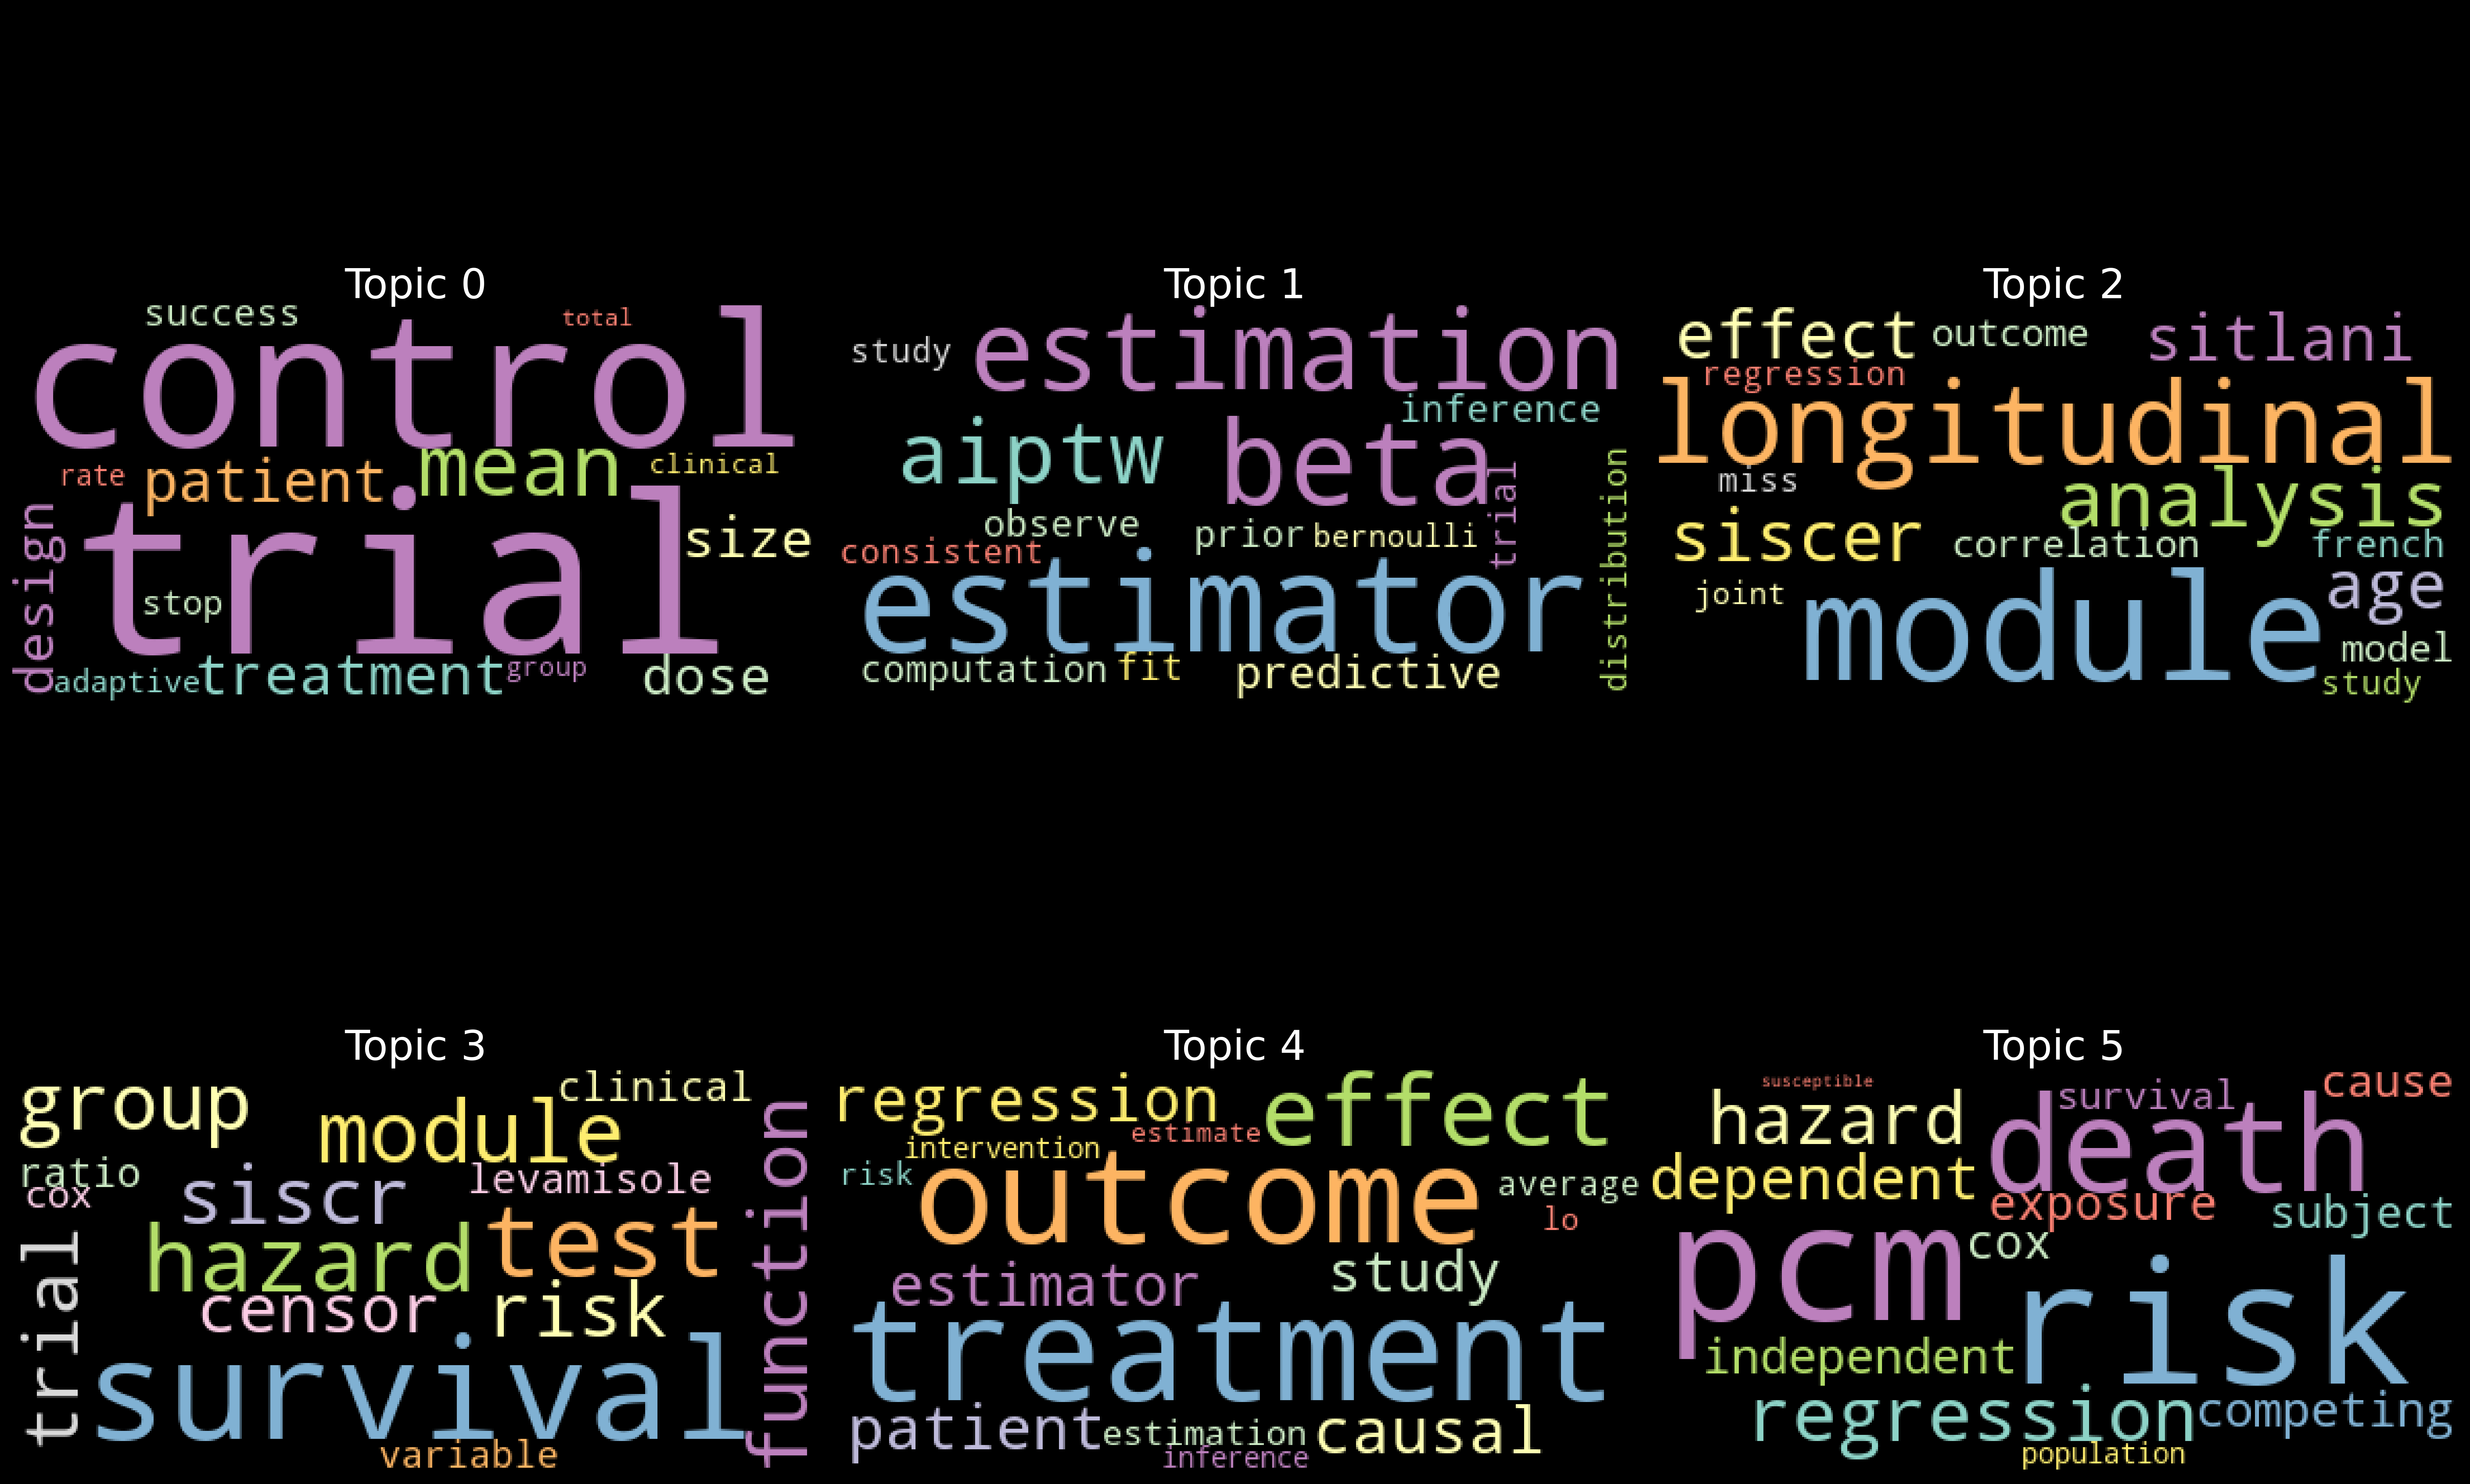

In [ ]:
wordcloud_store = []

for j in range(len(words_per_topic)):
    wc_text = ""
    this_df = tm_df[tm_df["topic_ID"] == j]
    for index, row in this_df.iterrows():
        weighted_word = (row['word'] + " ") * row['weight']
        wc_text = wc_text + weighted_word
    wordcloud_s = None
    this_title = "Topic # " + str(j)
    # change color map to whatever you want
    wordcloud_s = wordcloud.WordCloud(random_state=69, 
                                      background_color='black', colormap='Set3',
                                      collocations=False).generate(wc_text)
                                    
    # uncomment below to make individual plots
    # plot_cloud(wordcloud_s, wtitle=this_title)
    wordcloud_store.append(wordcloud_s)

plot_several_clouds(wordcloud_store, "Topic", verbose=True)
print("\n\n finished plotting clouds at: ", datetime.now())

## Predict Topics

predicts a topic for a given document

In [ ]:
def topic_prediction(my_document):
    string_input = [my_document]
    X = vect.transform(string_input)
    # Convert sparse matrix to gensim corpus.
    corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
    output = list(ldamodel[corpus])[0]
    topics = sorted(output,key=lambda x:x[1],reverse=True)
    return topics[0][0]
 
# topic_prediction(my_document)

# Ideas for future

1. additional viz methods like [wordcloud](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#13.-t-SNE-Clustering-Chart)
2. better viz, from ted underwood [link here](https://tedunderwood.com/2012/11/11/visualizing-topic-models/)
3. further documentation from gensim
    * [wikipedia experiments](https://radimrehurek.com/gensim/wiki.html#latent-dirichlet-allocation)
    * [LDA tutorial](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html)
4. link 4 [here](http://ethen8181.github.io/machine-learning/clustering/topic_model/LDA.html)
5. Guide to Build Best LDA model using Gensim Python [here](https://thinkinfi.com/guide-to-build-best-lda-model-using-gensim-python/)
6. Gensim LDA: Tips and Tricks mining the details [here](https://miningthedetails.com/blog/python/lda/GensimLDA/)
